In [6]:
import os
import sys
sys.path.append(os.path.expanduser('~'))
from variational_diffusion_cdm.data.astro_dataset import AstroDataModule, get_astro_data
import torch
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from PIL import Image
from diffusers import DDPMScheduler
from diffusers.utils import make_image_grid
import matplotlib.pyplot as plt

In [58]:
torch.cuda.is_available()
torch.cuda.device_count()

0

In [3]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

In [3]:
dm = AstroDataModule(
        train_transforms=None,
        test_transforms=None,
        num_workers=8,
        batch_size=12,
        dataset= 'Astrid'
    )
dm.setup(stage=None)

In [11]:
@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 12
    eval_batch_size = 12  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "diffuser-cdm"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "Klin0604/diffuser_cdm"  # the name of the repository to create on the HF Hub
    hub_private_repo = True
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

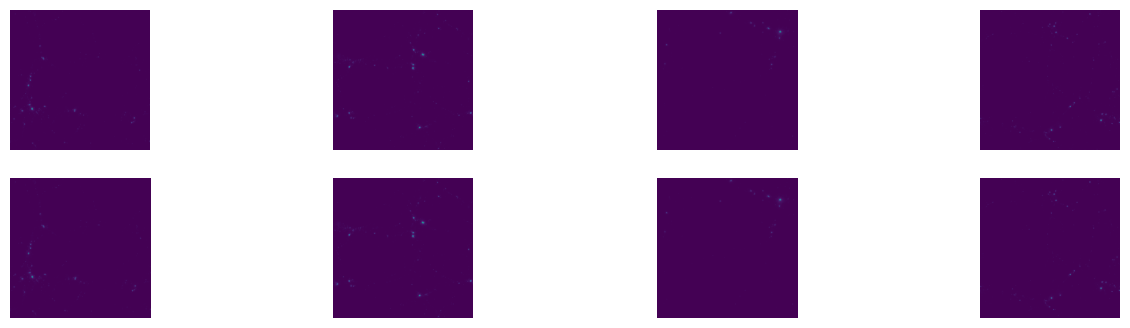

In [5]:
dataset = dm.train_data
fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4][0]):
    image = image.reshape([256,256])
    axs.flat[i].imshow(image)
    axs.flat[i].set_axis_off()
for i, image in enumerate(dataset[:4][1]):
    image = image.reshape([256,256])
    axs.flat[i+4].imshow(image)
    axs.flat[i+4].set_axis_off()
fig.show()


In [4]:
dm_aug = get_astro_data(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    )

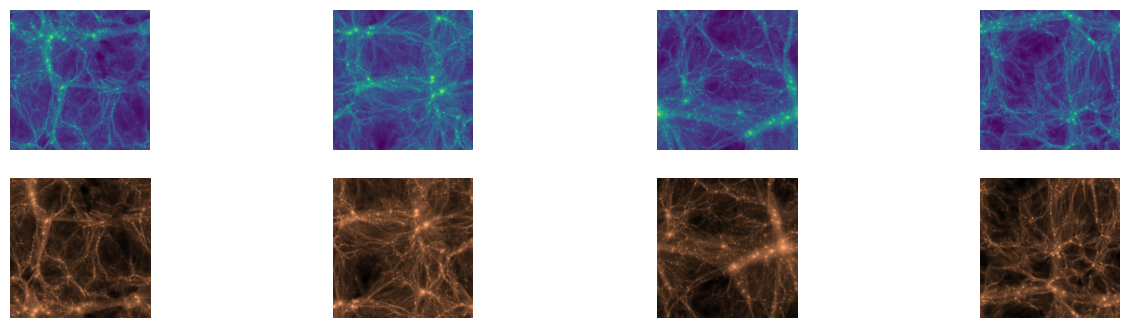

In [9]:
dataset = dm_aug.train_data
fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4][0]):
    image = image.reshape([256,256])
    axs.flat[i].imshow(image)
    axs.flat[i].set_axis_off()
for i, image in enumerate(dataset[:4][1]):
    image = image.reshape([256,256])
    axs.flat[i+4].imshow(image, cmap='copper')
    
    axs.flat[i+4].set_axis_off()
fig.show()


In [12]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [30]:
sample_image = dm_aug.train_data[0][0].unsqueeze(0)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [34]:
im = Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 250).squeeze().numpy()[0])
im.show()

display: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dm_aug.train_dataloader()) * config.num_epochs),
)

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [56]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step in range(len(train_dataloader)):
            conditioning, target = next(iter(train_dataloader))
            conditioning = conditioning[step]
            target = target[step]
            
            # Sample noise to add to the images
            noise = torch.randn(conditioning.shape, device=conditioning.device)
            bs = conditioning.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=conditioning.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(conditioning, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, target)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [57]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, dm_aug.train_dataloader(), lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on CPU.


  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [128] and input of shape [128, 256, 256]

In [46]:
np.shape(dm_aug.train_data)

(12000, 2, 1, 256, 256)

In [55]:
train = next(iter(dm_aug.train_dataloader()))
print(np.shape(train))

(2, 12, 1, 256, 256)


In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])